In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import f1_score
import sklearn
import itertools
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')
g = torch.Generator().manual_seed(21456789)
device = 'cpu'

Using device: cuda


In [2]:
import sklearn.metrics as metrics

In [ ]:
df_klein = pd.read_csv('Kleinstiver_5gRNA_wholeDataset.csv')
df_circle = pd.read_excel('CIRCLE-seq_6gRNA_active_offTargets.xlsx')
df_circle = df_circle[df_circle['Off-target Sequence'].apply(len) == 23]

df_klein = df_klein[40777:].reset_index()

df = pd.DataFrame()
df['TargetSequence'] = list(list(df_klein['sgRNA_seq']) + list(df_circle['TargetSequence']))
df['Off-target Sequence'] = list(list(df_klein['off_seq']) + list(df_circle['Off-target Sequence']))
df['label'] = df_klein['label'].to_list() + [1] * len(df_circle)
                                 
df_test = pd.DataFrame()
df_test = df[df['TargetSequence'].isin(['GGCGGCTGCACAACCAGTGGNGG','GCATACAGTGATTTGATGAANGG '])]
df =df[~df['TargetSequence'].isin(['GGCGGCTGCACAACCAGTGGNGG','GCATACAGTGATTTGATGAANGG'])]


In [4]:
df_valid = pd.DataFrame()
df_invlalid = pd.DataFrame()
df_valid = df[df['label'] == 1]
df_invlalid = df[df['label']==0]

In [5]:
df_valid.reset_index(inplace=True)
df_valid.drop(['index'], inplace=True,axis=1)
df_invlalid.reset_index(inplace=True)
df_invlalid.drop(['index'], inplace=True,axis=1)

/tmp/ipykernel_6886/177922544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.drop(['index'], inplace=True,axis=1)
/tmp/ipykernel_6886/177922544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_invlalid.drop(['index'], inplace=True,axis=1)


In [6]:
base_to_index = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'N': 4, '-': 5}
def return_lst_basepair(base_pair):
    empty_lst = [0,0,0,0,0,0]
    empty_lst[base_to_index[base_pair]] = 1
    return empty_lst

### Converting the Off-tagret sequence into a one hot encoded array of size (23,6)

In [7]:
x_list_valid = []
x_list_invalid = []
for index, row in df_invlalid.iterrows():
    x_list_invalid.append(np.concatenate((np.array([return_lst_basepair(i.upper()) for i in row['Off-target Sequence']]),np.array([return_lst_basepair(i.upper()) for i in row['TargetSequence']])),axis=0))
for index, row in df_valid.iterrows():
    x_list_valid.append(np.concatenate((np.array([return_lst_basepair(i.upper()) for i in row['Off-target Sequence']]),np.array([return_lst_basepair(i.upper()) for i in row['TargetSequence']])),axis=0))    

In [8]:
y_valid = np.array(df_valid['label'])
y_invalid = np.array(df_invlalid['label'])
x_list_valid = np.array(x_list_valid)
x_list_invalid = np.array(x_list_invalid)

In [9]:
len(y_invalid)

47134

In [10]:
y_valid_to_test = y_valid[6000:]
y_valid = y_valid[:6000]
y_invalid_to_test = y_invalid[45934:]
y_invalid = y_invalid[:45934]
x_list_valid_to_test = x_list_valid[6000:]
x_list_valid = x_list_valid[:6000]
x_list_invalid_to_test = x_list_invalid[45934:]
x_list_invalid = x_list_invalid[:45934]

## Model

In [ ]:
class OffTargetPredector(torch.nn.Module):

    def __init__(self):
        super(OffTargetPredector,self).__init__()
        # define my model here 
        self.attention = torch.nn.MultiheadAttention(embed_dim=276, num_heads=3, batch_first=True)
        self.dense1 = torch.nn.Linear(46*6,1028,device=device,bias=False)
        self.batchNorm1 = torch.nn.BatchNorm1d(1028)
        self.dense2 = torch.nn.Linear(1028,512,device=device,bias=False)
        self.batchNorm2 = torch.nn.BatchNorm1d(512)
        self.dense3 = torch.nn.Linear(512,512,device=device,bias=False)
        self.batchNorm3 = torch.nn.BatchNorm1d(512)
        self.dense4 = torch.nn.Linear(512,256,device=device,bias=False)
        self.batchNorm4 = torch.nn.BatchNorm1d(256)
        self.dense5 = torch.nn.Linear(256,128,device=device,bias=False)
        self.batchNorm5 = torch.nn.BatchNorm1d(128)
        self.dense6 = torch.nn.Linear(128,64,device=device,bias=False)
        self.batchNorm6 = torch.nn.BatchNorm1d(64)
        self.dense7 = torch.nn.Linear(64,32,device=device,bias=False)
        self.batchNorm7 = torch.nn.BatchNorm1d(32)
        self.dense8 = torch.nn.Linear(32,16,device=device,bias=False)
        self.batchNorm8 = torch.nn.BatchNorm1d(16)
        self.dense9 = torch.nn.Linear(16,8,device=device)
        self. out = torch.nn.Linear(8,1,device=device)    
        self.dropout = torch.nn.Dropout(0.4) 
        
    def forward(self, input):
    # Apply multi-headed attention
        attn_output, _ = self.attention(input, input, input)
        attn_output = attn_output.view(attn_output.size(0), -1)  # Flatten the output for the dense layers
        
        d1 = self.dense1(attn_output)
        d1 = torch.nn.functional.relu(self.batchNorm1(d1))
        d1 = self.dropout(d1)
        d2 = self.dense2(d1)
        d2 = torch.nn.functional.relu(self.batchNorm2(d2))
        d2 = self.dropout(d2)
        d4 = self.dense4(d2)
        d4 = torch.nn.functional.relu(self.batchNorm4(d4))
        d4 = self.dropout(d4)
        d5 = self.dense5(d4)
        d5 = torch.nn.functional.relu(self.batchNorm5(d5))
        d5 = self.dropout(d5)
        d6 = self.dense6(d5)
        d6 = torch.nn.functional.relu(self.batchNorm6(d6))
        d6 = self.dropout(d6)
        d7 = self.dense7(d6)
        d7 = torch.nn.functional.relu(self.batchNorm7(d7))
        d7 = self.dropout(d7)
        d8 = self.dense8(d7)
        d8 = torch.nn.functional.relu(self.batchNorm8(d8))
        d8 = self.dropout(d8)
        d9 = torch.nn.functional.relu(self.dense9(d8))
        d9 = self.dropout(d9)
        final = torch.nn.functional.sigmoid(self.out(d9))
        return final

In [43]:
# write the training loop
for _ in range(50):
    optimizer.zero_grad()
    # ------- Apply bootstrapping apprach to get equal numbers of 0's and 1's labels -------#
    # batch size of 64
    ix_zero = torch.randint(0,len(x_list_invalid),(batch_size,),device=device).cpu() 
    ix_one =  torch.randint(0,len(x_list_valid),(batch_size,),device=device).cpu() 
    zeros = x_list_invalid[ix_zero]
    ones = x_list_valid[ix_one]
    target_invalid = y_invalid[ix_zero]
    target_valid = y_valid[ix_one]
    
    combined_in = np.concatenate((zeros,ones),axis=0)
    combined_taget = np.concatenate((target_invalid,target_valid),axis=0)

    combined_in,combined_taget = sklearn.utils.shuffle(combined_in,combined_taget)

    #-------- Forward Pass --------#
    output = model(torch.tensor(combined_in,device=device,dtype=torch.float).view(batch_size*2,46*6))
    loss = cross_entropy_loss(output.view(batch_size*2),torch.tensor(combined_taget,device=device,dtype=torch.float).view(batch_size*2))/(batch_size*2)

    print(f"Epoc = {_}, Loss = {loss}")

    loss.backward()
    optimizer.step()

Epoc = 0, Loss = 3.6710686683654785
Epoc = 1, Loss = 3.6698429584503174
Epoc = 2, Loss = 3.669523000717163
Epoc = 3, Loss = 3.671333074569702
Epoc = 4, Loss = 3.671379804611206
Epoc = 5, Loss = 3.668194532394409
Epoc = 6, Loss = 3.6657891273498535
Epoc = 7, Loss = 3.6658246517181396
Epoc = 8, Loss = 3.6650962829589844
Epoc = 9, Loss = 3.6674556732177734
Epoc = 10, Loss = 3.6665546894073486
Epoc = 11, Loss = 3.6667370796203613
Epoc = 12, Loss = 3.6648805141448975
Epoc = 13, Loss = 3.664130449295044
Epoc = 14, Loss = 3.6649646759033203
Epoc = 15, Loss = 3.6649813652038574
Epoc = 16, Loss = 3.66176176071167
Epoc = 17, Loss = 3.662205219268799
Epoc = 18, Loss = 3.6622395515441895
Epoc = 19, Loss = 3.6648154258728027
Epoc = 20, Loss = 3.661130666732788
Epoc = 21, Loss = 3.6605820655822754
Epoc = 22, Loss = 3.659935474395752
Epoc = 23, Loss = 3.6589395999908447
Epoc = 24, Loss = 3.658836841583252
Epoc = 25, Loss = 3.6588728427886963
Epoc = 26, Loss = 3.661057949066162
Epoc = 27, Loss = 3.660

In [12]:
model = OffTargetPredector()
cross_entropy_loss =  torch.nn.CrossEntropyLoss()
# mae = torch.nn.losscross_entropy_loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
 # 1000 samples per df, i.e total 2000 in one forward pass

/home/atharv/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
batch_size = 1000
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)
torch.save(model,'probs_model')

In [11]:
model_lo = OffTargetPredector()
model_lo = torch.load('probs_model')
model_lo.eval()

OffTargetPredector(
  (dense1): Linear(in_features=276, out_features=1028, bias=False)
  (batchNorm1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=1028, out_features=512, bias=False)
  (batchNorm2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=512, out_features=512, bias=False)
  (batchNorm3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=512, out_features=256, bias=False)
  (batchNorm4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=256, out_features=128, bias=False)
  (batchNorm5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense6): Linear(in_features=128, out_features=64, bias=False)
  (batchNorm6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

## Testing the Model

In [ ]:
# testing the ratio for f1 score, start with 90:10 ig till 10:90
f1score = []
auroc = []
ratio = []
X_test_lst = []
y_test_lst = []
preds_lst= []
preds_lst_probs = []
for i in range(0,79,2):

    x_list_valid = []
    x_list_invalid = []
    for index, row in df_invlalid.iterrows():
        x_list_invalid.append(np.concatenate((np.array([return_lst_basepair(i.upper()) for i in row['Off-target Sequence']]),np.array([return_lst_basepair(i.upper()) for i in row['TargetSequence']])),axis=0))
    for index, row in df_valid.iterrows():
        x_list_valid.append(np.concatenate((np.array([return_lst_basepair(i.upper()) for i in row['Off-target Sequence']]),np.array([return_lst_basepair(i.upper()) for i in row['TargetSequence']])),axis=0))    
    y_valid = np.array(df_valid['label'])[6000:]
    y_invalid = np.array(df_invlalid['label'])[45934:]
    x_list_valid = np.array(x_list_valid)[6000:]
    x_list_invalid = np.array(x_list_invalid)[45934:]

    x = int(len(y_valid) * ((90 - i)/(100)))
    y = int(len(y_valid) * ((10 + i)/(100)))
    y_valid_to_test = y_valid[:y]
    # y_valid = y_valid[:6500]
    y_invalid_to_test = y_invalid[:x]
    # y_invalid = y_invalid[:45934]
    x_list_valid_to_test = x_list_valid[:y]
    # x_list_valid = x_list_valid[:6500]
    x_list_invalid_to_test = x_list_invalid[:x]
    # x_list_invalid = x_list_invalid[:45934]
    print(x,y)
    ratio.append(x / y)
    combined_in_test = np.concatenate((x_list_invalid_to_test,x_list_valid_to_test),axis=0)
    combined_taget_test = np.concatenate((y_invalid_to_test,y_valid_to_test),axis=0)
    # predict
    train_pred = model(torch.tensor(combined_in_test,device=device,dtype=torch.float).view(len(combined_in_test),46*6))
    lst_tst = [np.round(i.item()) for i in train_pred]
    X_test_lst.append(combined_in_test)
    y_test_lst.append(combined_taget_test)
    preds_lst.append(lst_tst)
    preds_lst_probs.append(train_pred)

    f1score.append(f1_score(combined_taget_test,lst_tst))
    auroc.append(metrics.roc_auc_score(combined_taget_test,lst_tst))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.grid(True)
plt.xscale('symlog', linthresh=1, linscale=1)

# Customizing ticks for better rea
#dability
plt.xticks([[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2.0,3.0,4.0]],
           ['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','2.0','3.0','4.0'])

plt.xticks(ticks)
plt.plot(ratio,f1score)
plt.title("Invlid is to Valid Ratio vs F1 Score")
plt.xlabel("Invalid : Valid")
plt.ylabel("F1 Score")
plt.show()

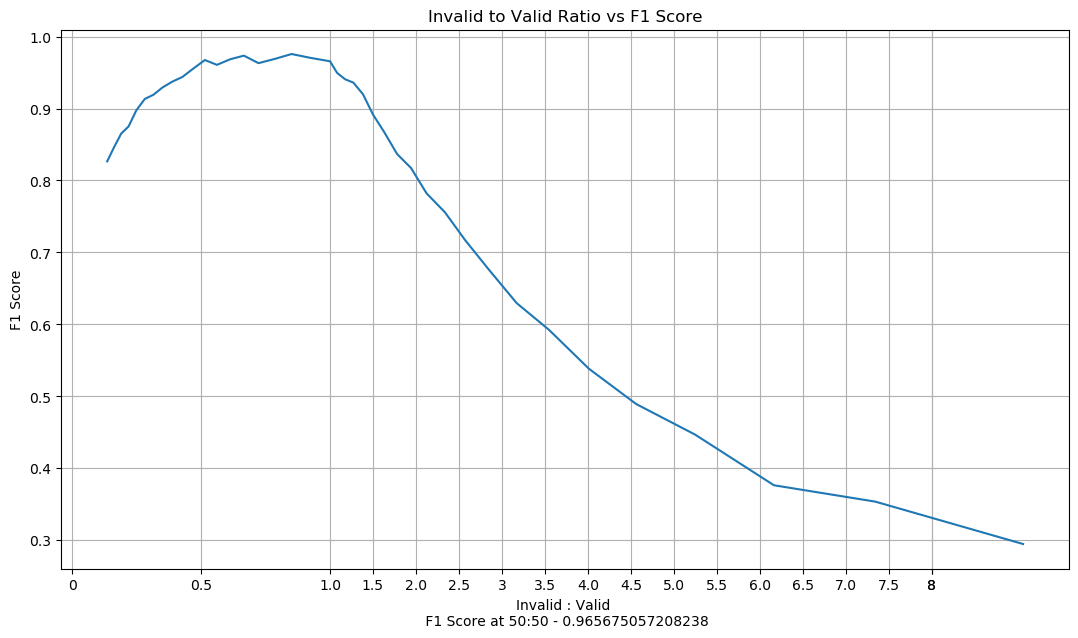

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Custom transformation function
def custom_transform(x):
    if x <= 1:
        return x
    else:
        return 1 + (x - 1) / 3

# Apply the custom transformation to x data
x_transformed = [custom_transform(xi) for xi in ratio]

plt.figure(figsize=(13, 7))
plt.grid(True)

# Plotting the lists with transformed x data
plt.plot(x_transformed, f1score)

# Adding titles and labels
plt.title("Invalid to Valid Ratio vs F1 Score")
plt.xlabel(f"Invalid : Valid \n F1 Score at 50:50 - {f1score[20]}")
plt.ylabel("F1 Score")

# Customizing x-axis ticks and labels
original_ticks = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4.0, 4.5,5.0,5.5,6.0,6.5,7.0,7.5,8,8]
transformed_ticks = [custom_transform(t) for t in original_ticks]
plt.xticks(transformed_ticks, original_ticks)

# Display the plot
plt.show()


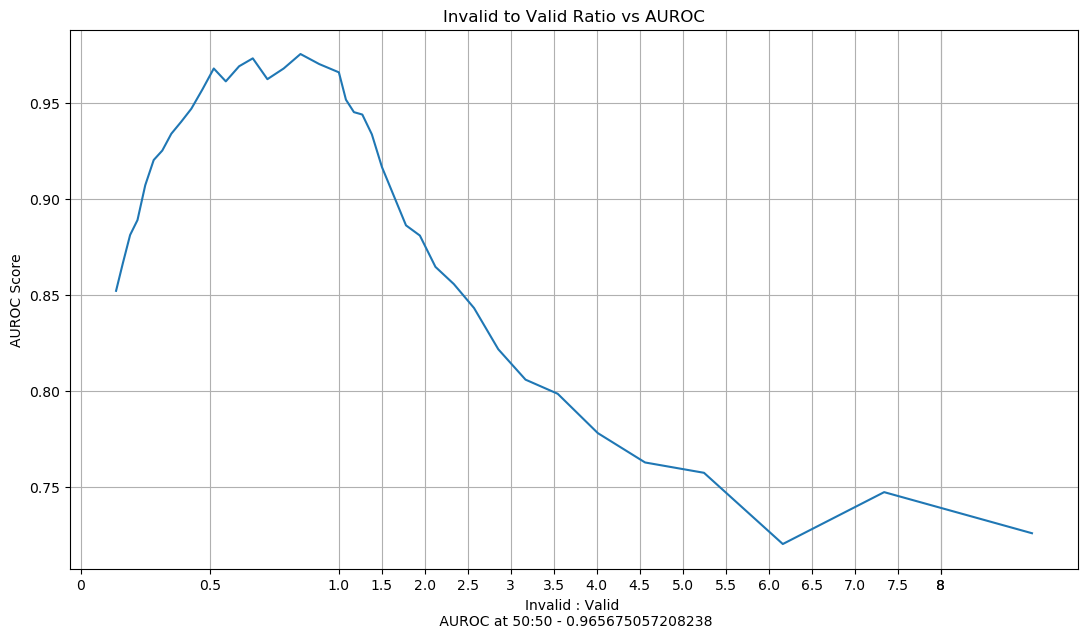

In [60]:
# Custom transformation function
def custom_transform(x):
    if x <= 1:
        return x
    else:
        return 1 + (x - 1) / 3

# Apply the custom transformation to x data
x_transformed = [custom_transform(xi) for xi in ratio]

plt.figure(figsize=(13, 7))
plt.grid(True)

# Plotting the lists with transformed x data
plt.plot(x_transformed, auroc)

# Adding titles and labels
plt.title("Invalid to Valid Ratio vs AUROC")
plt.xlabel(f"Invalid : Valid \n AUROC at 50:50 - {f1score[20]}")
plt.ylabel("AUROC Score")

# Customizing x-axis ticks and labels
original_ticks = [0, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4.0, 4.5,5.0,5.5,6.0,6.5,7.0,7.5,8,8]
transformed_ticks = [custom_transform(t) for t in original_ticks]
plt.xticks(transformed_ticks, original_ticks)

# Display the plot
plt.show()

In [13]:
import sklearn.metrics as metrics

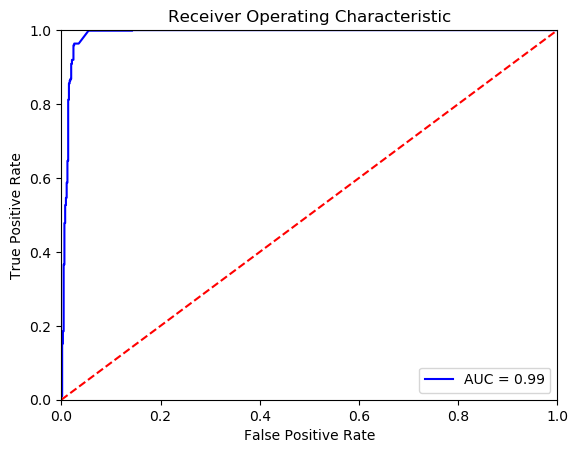

In [ ]:
preds = preds_lst_probs[20].detach().numpy() 
fpr, tpr, threshold = metrics.roc_curve(y_test_lst[20], preds,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# # method II: ggplot
# from ggplot import *
# df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
# ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')

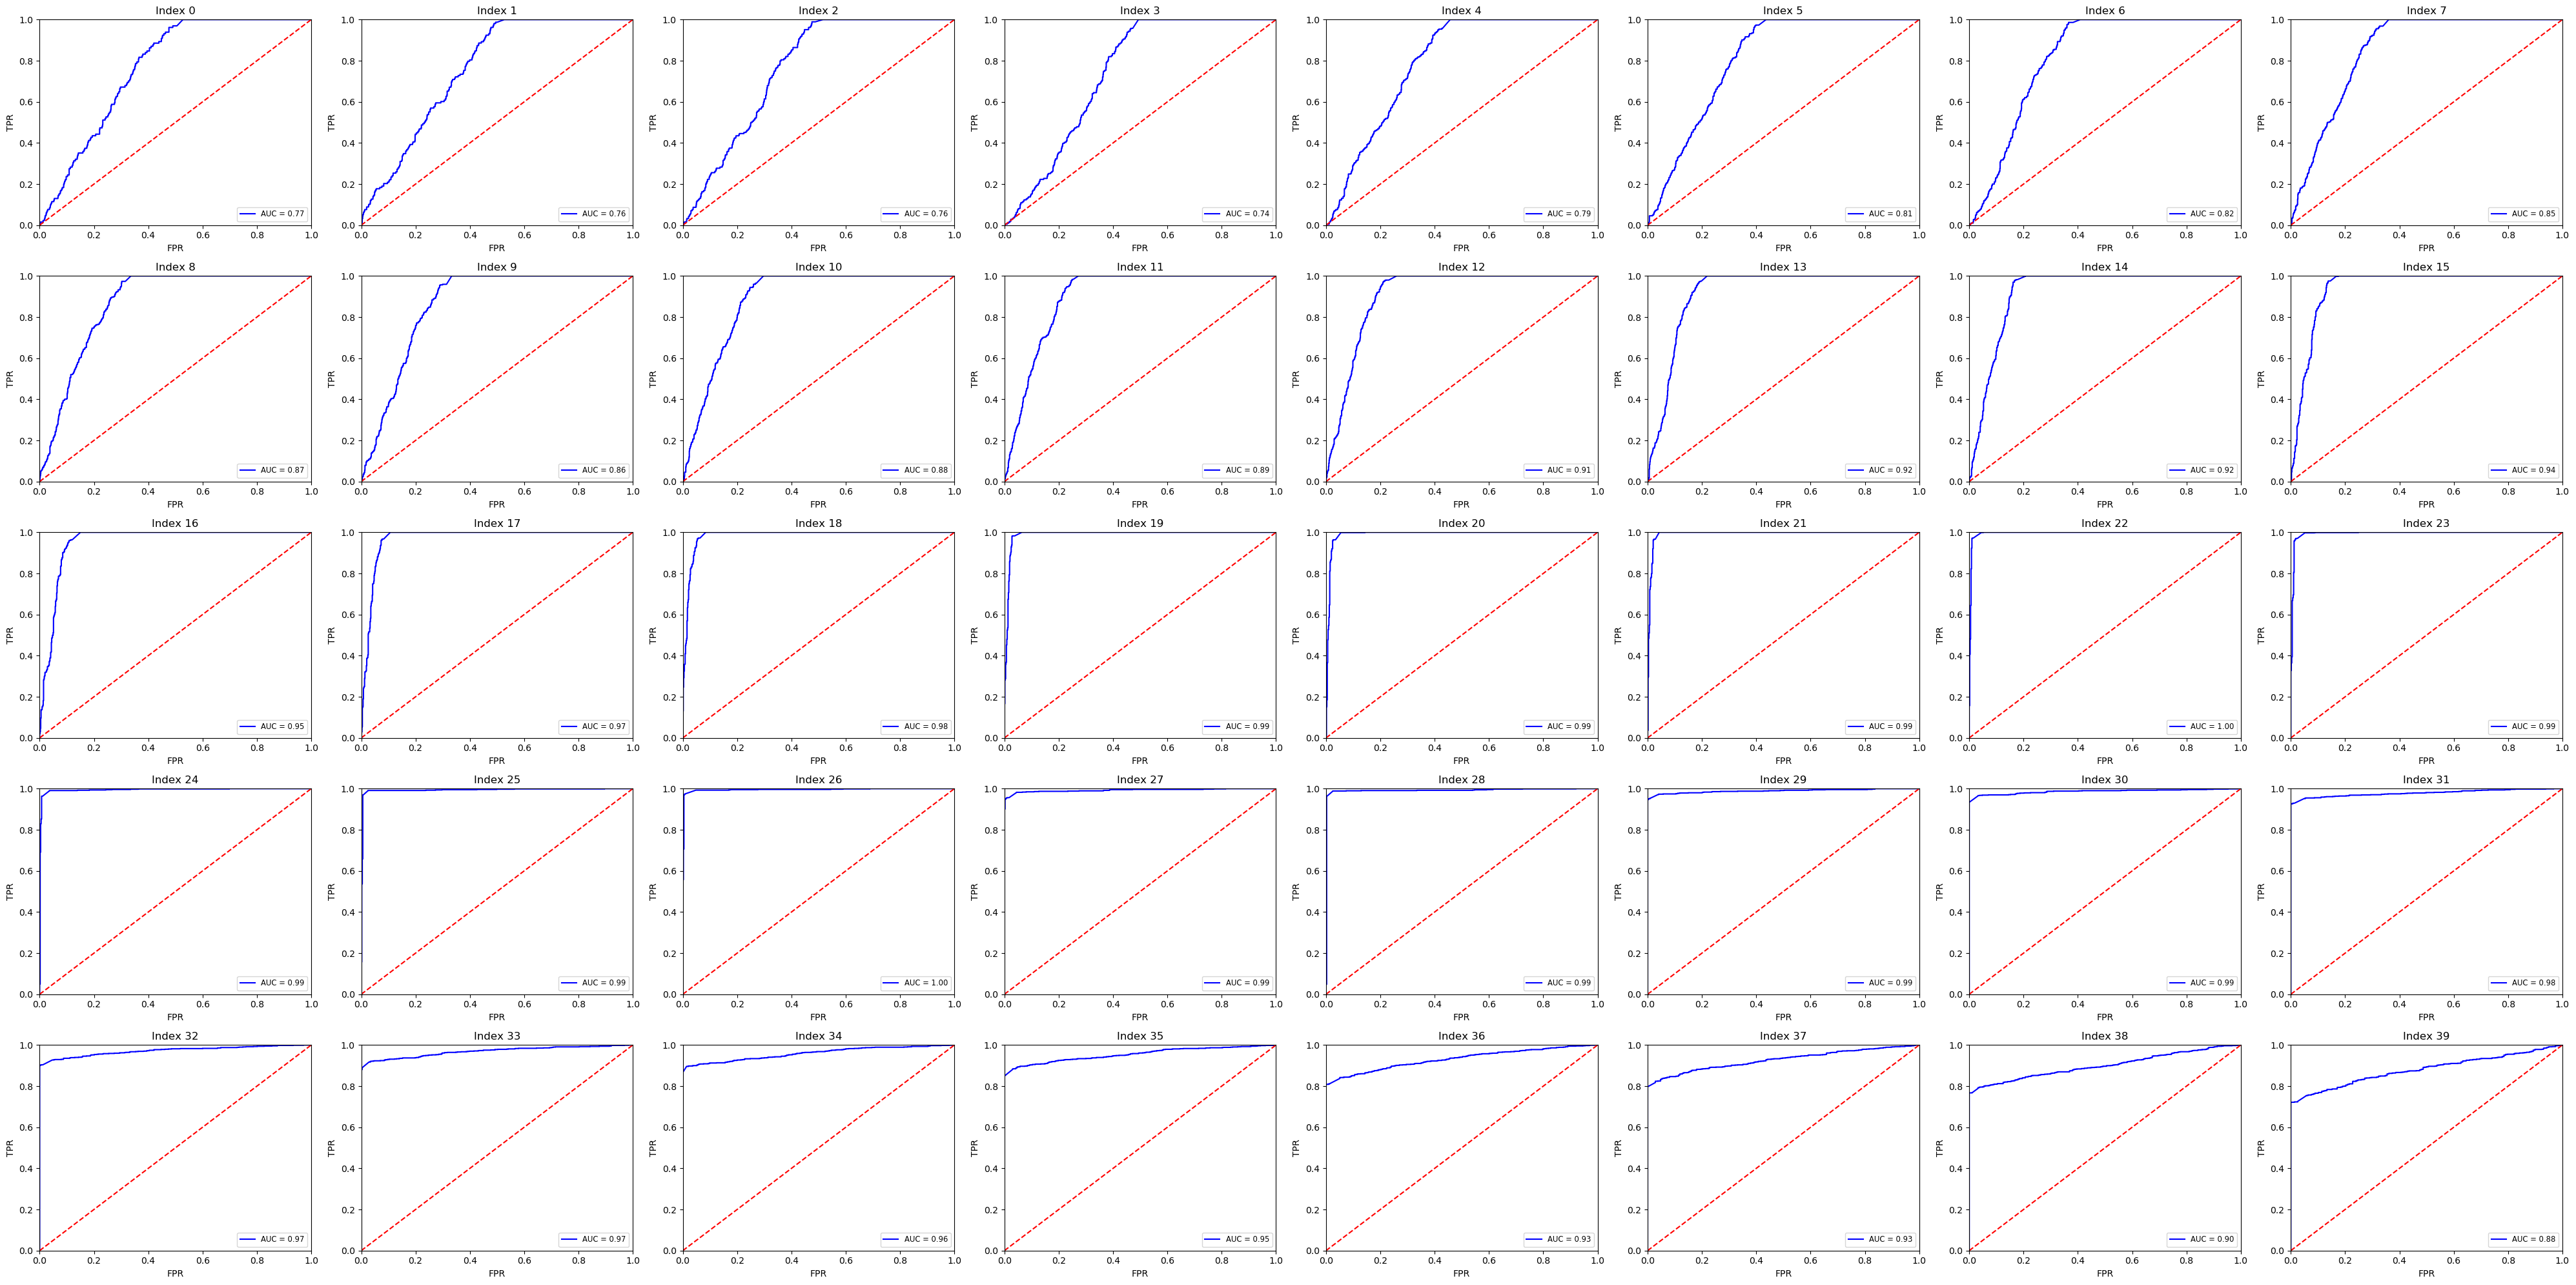

In [53]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Set up a grid of subplots, e.g., 5x8 for 40 plots
fig, axs = plt.subplots(5, 8, figsize=(40, 20))  # Adjust the grid and size as needed

# Loop through indices and plot each ROC curve in its respective subplot
for i in range(40):
    preds = preds_lst_probs[i].detach().numpy()
    fpr, tpr, threshold = metrics.roc_curve(y_test_lst[i], preds, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    
    ax = axs[i // 8, i % 8]  # Determine subplot position
    ax.plot(fpr, tpr, 'b', label=f'AUC = {roc_auc:.2f}')
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f'Index {i}')
    ax.legend(loc='lower right', fontsize='small')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [54]:
metrics.precision_score(y_test_lst[20],preds_lst[20])

0.975

In [44]:
combined_in_test = np.concatenate((x_list_invalid_to_test,x_list_valid_to_test),axis=0)
combined_taget_test = np.concatenate((y_invalid_to_test,y_valid_to_test),axis=0)
# predict
train_pred = model(torch.tensor(combined_in_test,device=device,dtype=torch.float).view(len(combined_in_test),46*6))
lst_tst = [np.round(i.item()) for i in train_pred]

In [45]:
f1_score(combined_taget_test,lst_tst)

0.9807840122982322

In [46]:
accuracy_score(combined_taget_test,lst_tst)

0.9801508535132989

In [47]:
roc_auc_score(combined_taget_test,lst_tst)

0.9807831058882992

## Mismatch frequencies

In [ ]:
for i in output:
    print(i)

In [126]:
lst = [np.round(i.item()) for i in output]

In [127]:
(combined_taget - lst).sum()

4.0

In [921]:
generated_df = pd.read_csv('prediction.csv')

In [778]:
test_list = []
for index, row in generated_df.iterrows():
    test_list.append(np.concatenate((np.array([return_lst_basepair(i) for i in row['offtarget']]),np.array([return_lst_basepair(i) for i in row['ontarget']])),axis=0))
test_list = np.array(test_list)    

In [782]:
pred_out = model(torch.tensor(test_list,device=device,dtype=torch.float).view(len(test_list),46*6))

In [4]:
df_predicted = pd.read_csv('prediction.csv')

In [134]:
df_predicted

,Unnamed: 0,ontarget,offtarget
0,0,GGAATCCCTTCTGCAGCACCNGG,GAAGCCCCTTCCTCTGCCCCNGG
1,1,GGAATCCCTTCTGCAGCACCNGG,AGGTCTCCTTCCGCAGCCCCNGG
2,2,GGAATCCCTTCTGCAGCACCNGG,GCAACCCCCTCNGCNGCCCCNGG
3,3,GGAATCCCTTCTGCAGCACCNGG,GCAAAACATTCCGCNGCCCCNGG
4,4,GGAATCCCTTCTGCAGCACCNGG,GCAA-CCATTC-GCCGCCCCNGG
...,...,...,...
13408,13408,GGAATCCCTTCTGCAGCACCNGG,GACATCCATTAGGCGGCCCCNGG
13409,13409,GGAATCCCTTCTGCAGCACCNGG,GCAA-CCCCTANGGAGCCCCNGG
13410,13410,GGAATCCCTTCTGCAGCACCNGG,GGTAAACACTCTGCAGCCCCNGG
13411,13411,GGAATCCCTTCTGCAGCACCNGG,GGACTTTCTCCTGCNGCCCCNGG


In [126]:
len(df_predicted['offtarget'].unique())

13413

In [131]:
common_off_targets = pd.merge(df_og[['off_seq']], df_predicted[['offtarget']], left_on='off_seq',right_on='offtarget')

In [132]:
common_off_targets

,off_seq,offtarget


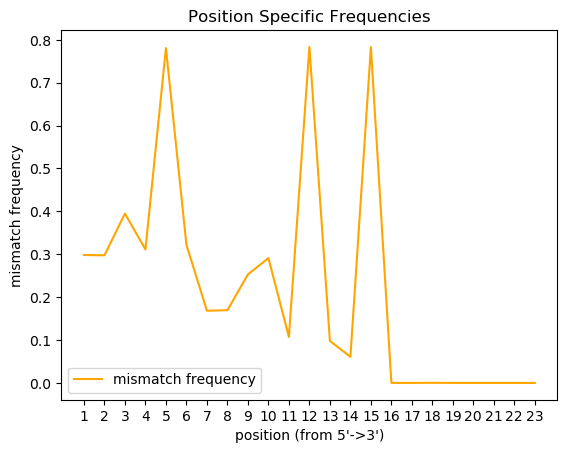

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sequence_length = len(df_predicted['offtarget'].iloc[0])
total_sequences = len(df_predicted)

# Initialize a list to count mismatches at each position
mismatch_counts = np.zeros(sequence_length)

# Compare each position in the sequences
for i in range(sequence_length):
    # Get the base at each position for all sequences
    bases = df_predicted['offtarget'].str[i]
    # Calculate the mismatch frequency for this position
    mismatch_counts[i] = bases.value_counts().iloc[1:].sum() / total_sequences

# Plotting the mismatch frequency
positions = np.arange(1, sequence_length + 1)
plt.plot(positions, mismatch_counts, label='mismatch frequency', color='orange')

# Customizing the plot
plt.title('Position Specific Frequencies')
plt.xlabel('position (from 5\'->3\')')
plt.ylabel('mismatch frequency')
plt.xticks(positions)
plt.legend()
plt.show()

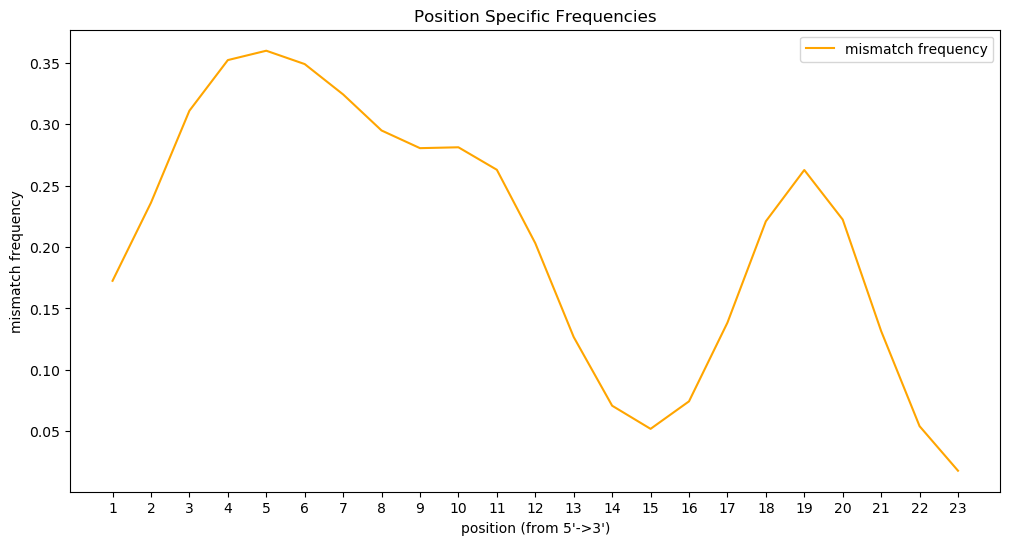

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Assuming all sequences are of the same length
sequence_length = len(df_predicted['offtarget'].iloc[0])
total_sequences = len(df_predicted)

# Initialize a list to count mismatches at each position
mismatch_counts = np.zeros(sequence_length)

# Compare each position in the sequences
for i in range(sequence_length):
    # Get the base at each position for all sequences
    bases = df_predicted['offtarget'].str[i]
    # Calculate the mismatch frequency for this position
    mismatch_counts[i] = bases.value_counts().iloc[1:].sum() / total_sequences

# Apply Gaussian smoothing to the mismatch frequency
smoothed_mismatch_counts = gaussian_filter1d(mismatch_counts, sigma=1.5)

# Plotting the mismatch frequency
positions = np.arange(1, sequence_length + 1)
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.plot(positions, smoothed_mismatch_counts, label='mismatch frequency', color='orange')

# Customizing the plot
plt.title('Position Specific Frequencies')
plt.xlabel('position (from 5\'->3\')')
plt.ylabel('mismatch frequency')
plt.xticks(positions)
plt.legend()
plt.show()
